Objective: To develop and evaluate a text classification system capable of categorizing user feedback into four distinct classes: Feature Requests, Problem Discovery, Information Giving, and Information Seeking.

**0. Installing Necessary Libraries**

In [1]:
!pip install pandas

In [2]:
!pip install openpyxl

In [3]:
!pip install transformers==4.57.5

In [4]:
!pip install torch

In [5]:
!pip install -U accelerate

In [6]:
!pip install wordcloud

In [7]:
!pip install matplotlib

In [8]:
!pip install seaborn

**1. Data Exploration:**
Before model development, we explore the dataset to understand class distributions and identify common linguistic patterns.

**1.1. Data Loading:** Load the raw dataset and inspect the first few entries to understand the feature structure.

In [9]:
import pandas as pd

# Excel file downloaded from: https://data.mendeley.com/datasets/5fk732vkwr/2
# Load dataset from local directory
df = pd.read_excel("review.xlsx")
df.head()

,id,review,class
0,39,Make it like better with a giant pig bigger th...,feature request
1,42,These screens are small enough without crowdin...,information giving
2,49,Dear Rovio; If you absolutely must continue tr...,information giving
3,56,App crashes when new power up notice pops up.,problem discovery
4,62,It would be nice to have an update that didn ...,information giving


**1.2. Class Distribution:** Visualizing the class distribution helps identify if the dataset is imbalanced, which informs our choice of evaluation metrics.

class
information giving     603
problem discovery      494
feature request        192
information seeking    101
Name: count, dtype: int64


/tmp/ipykernel_8836/1660518679.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


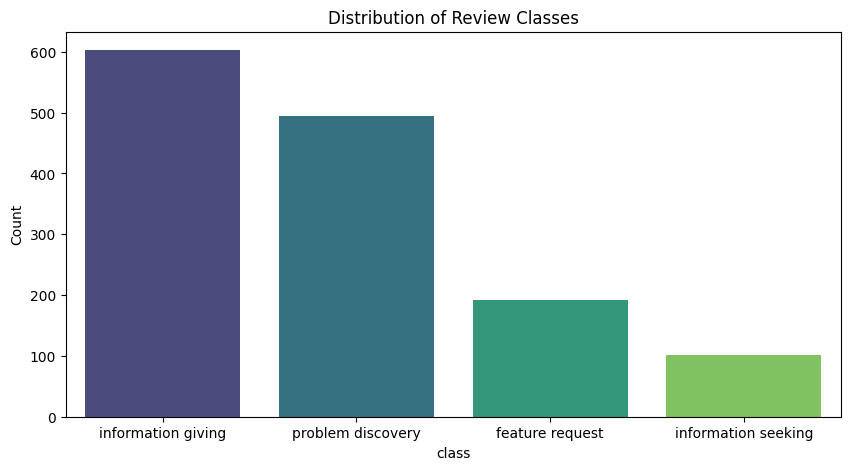

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Display distribution
class_counts = df['class'].value_counts()
print(class_counts)

# Visualization: Class Distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Review Classes')
plt.ylabel('Count')
plt.show()

**1.3. Linguistic Exploration (Word Clouds):** Generate class-specific word clouds to identify the "keywords" that distinguish one intent from another.

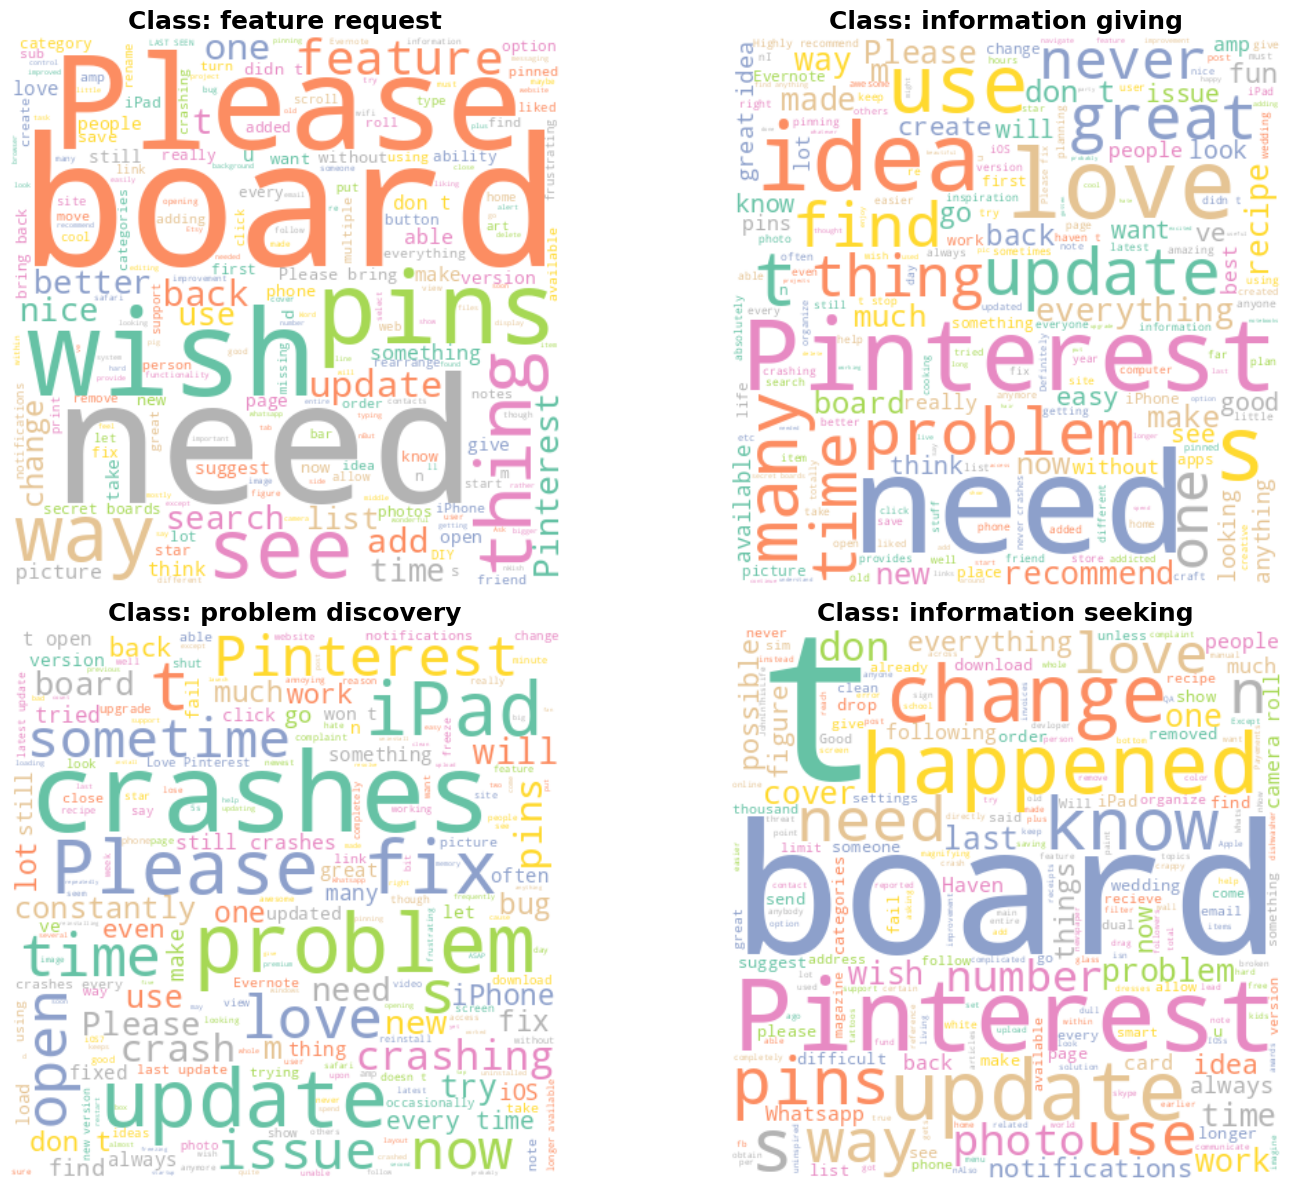

In [11]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# 1. Setup Stopwords
stopwords = set(STOPWORDS)
stopwords.update(["and", "it", "to", "the", "is", "of", "app", "this", "my", "pin"])

# 2. Get the list of unique classes
classes = df['class'].unique()

# 3. Create a multi-plot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, cls in enumerate(classes):
    # Filter text by class using the original 'df'
    text_data = " ".join(review for review in df[df['class'] == cls].review)
    
    # Generate Word Cloud
    wordcloud = WordCloud(
        width=400, height=400,
        background_color='white',
        stopwords=stopwords,
        colormap='Set2'
    ).generate(text_data)
    
    # Plot in subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f"Class: {cls}", fontsize=18, fontweight='bold')
    axes[i].axis("off")

plt.tight_layout()
plt.show()

**2. Preprocessing and Feature Engineering**: Before modeling, the data must be cleaned, converted to numerical format and splitted for training and testing.

**2.1. Cleaning Data:** Removing non-informative column(id)

In [12]:
#removing extra id column
df_id_removed = df.drop(columns=['id'])
df_id_removed.head()

,review,class
0,Make it like better with a giant pig bigger th...,feature request
1,These screens are small enough without crowdin...,information giving
2,Dear Rovio; If you absolutely must continue tr...,information giving
3,App crashes when new power up notice pops up.,problem discovery
4,It would be nice to have an update that didn ...,information giving


**2.2. Encoding Target:** Convert categorical labels into numerical targets

In [13]:
#encoding target labels
#reference https://pbpython.com/categorical-encoding.html
find_replace = {"class":     {"feature request": 0, "problem discovery": 1, "information giving": 2, "information seeking": 3}}
target_encoded_df = df_id_removed.replace(find_replace)
target_encoded_df.head()

/tmp/ipykernel_8836/349531014.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_encoded_df = df_id_removed.replace(find_replace)


,review,class
0,Make it like better with a giant pig bigger th...,0
1,These screens are small enough without crowdin...,2
2,Dear Rovio; If you absolutely must continue tr...,2
3,App crashes when new power up notice pops up.,1
4,It would be nice to have an update that didn ...,2


In [14]:
target_encoded_df['class'].value_counts()

class
2    603
1    494
0    192
3    101
Name: count, dtype: int64

**2.3. Train Test Split:** Splitting 80% Data for training and 20% for testing

In [15]:
#train test split

In [16]:
from sklearn.model_selection import train_test_split

X = target_encoded_df['review']
y = target_encoded_df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1112,), (278,), (1112,), (278,))

**2.4. TF-IDF Vectorization:** Converting text to numerical features using an optimized TF-IDF vectorizer, fitted strictly on the training set to prevent data leakage.

In [18]:
#TF-IDF Feature Extraction
#TF - Term Frequency
#IDF - Inverse Document Frequecy

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(
#     lowercase=True,
#     stop_words='english',
#     max_df=0.9,
#     min_df=5,
#     ngram_range=(1, 2)
# ) 
# Accuracy: 0.6510791366906474

# tfidf = TfidfVectorizer(
#     analyzer="char_wb",
#     ngram_range=(3, 5),
#     min_df=3,
#     sublinear_tf=True
# )Accuracy: 0.6330935251798561

# tfidf = TfidfVectorizer(
#     lowercase=True,
#     stop_words='english',
#     max_df=0.9,
#     min_df=5,
#     ngram_range=(1, 3)
# ) Accuracy: 0.6510791366906474

tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_df=0.2,
    min_df=5,
    ngram_range=(1, 3),
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


**3. Implementing Machine Learning Model**

**3.1. Multinomial Naive Bayes:** A probabilistic baseline model.

In [20]:
#naive bayes

In [21]:
#training multinomial naive bayes
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
print("Training Completed")

Training Completed


In [22]:
#evaluating multinomial naive bayes
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_nb = nb_model.predict(X_test_tfidf)
y_score_nb = nb_model.predict_proba(X_test_tfidf) # Saved for ROC later

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# Confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.6510791366906474
              precision    recall  f1-score   support

           0       0.71      0.26      0.38        38
           1       0.74      0.64      0.68        99
           2       0.60      0.87      0.71       121
           3       1.00      0.15      0.26        20

    accuracy                           0.65       278
   macro avg       0.76      0.48      0.51       278
weighted avg       0.69      0.65      0.62       278

Confusion Matrix:

[[ 10   6  22   0]
 [  1  63  35   0]
 [  2  14 105   0]
 [  1   2  14   3]]


**3.2. Logistic Regression Algorithm:** A linear model utilizing class weighting to handle the imbalanced nature of the labels.

In [23]:
#logistic regression

In [24]:
#training logistic regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    n_jobs=-1
)

clf.fit(X_train_tfidf, y_train)
print("Training Completed")

Training Completed


/home/kebal/project/review-radar/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


In [25]:
#evaluating logistic regression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = clf.predict(X_test_tfidf)
y_score_lr = clf.predict_proba(X_test_tfidf) # Saved for ROC later

# Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Logistic Regression Accuracy: 0.5719424460431655

Classification Report:

              precision    recall  f1-score   support

           0       0.34      0.53      0.42        38
           1       0.82      0.62      0.71        99
           2       0.63      0.59      0.61       121
           3       0.21      0.35      0.26        20

    accuracy                           0.57       278
   macro avg       0.50      0.52      0.50       278
weighted avg       0.63      0.57      0.59       278

Confusion Matrix:

[[20  3 13  2]
 [ 9 61 21  8]
 [24 10 71 16]
 [ 5  0  8  7]]


**3.3. Transformer Model (BERT):** Using deep contextual embeddings for superior semantic understanding.

In [26]:
#BERT - Bidirectional Encoder Representations from Transformers

In [27]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Dataset wrapper
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = ReviewDataset(train_encodings, y_train.tolist())
test_dataset = ReviewDataset(test_encodings, y_test.tolist())

# Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

# Trainer
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=3,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=32,
#     eval_strategy='epoch',
#     save_strategy='epoch',
#     logging_dir='./logs',
#     logging_steps=10,
#     load_best_model_at_end=True
# )
# Epoch	Training Loss	Validation Loss	Accuracy	F1	Precision	Recall
# 1	0.559000	0.566445	0.802158	0.781403	0.798839	0.802158
# 2	0.457400	0.535569	0.798561	0.800712	0.808069	0.798561
# 3	0.198300	0.558971	0.805755	0.804878	0.804605	0.805755

#stopping training early to prevent overfitting

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_8836/2830338554.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.750400,0.769595,0.708633,0.677561,0.734063,0.708633
2,0.470100,0.600743,0.780576,0.772735,0.774581,0.780576


TrainOutput(global_step=140, training_loss=0.7221905333655221, metrics={'train_runtime': 46.4785, 'train_samples_per_second': 47.85, 'train_steps_per_second': 3.012, 'total_flos': 138292009544832.0, 'train_loss': 0.7221905333655221, 'epoch': 2.0})

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

pred_output = trainer.predict(test_dataset)

y_pred_bert = np.argmax(pred_output.predictions, axis=1)

print("BERT Accuracy:", accuracy_score(y_test, y_pred_bert))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_bert))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_bert))

# Convert logits to probabilities for ROC
import torch.nn.functional as F
import torch
logits = torch.from_numpy(pred_output.predictions)
y_score_bert = F.softmax(logits, dim=1).numpy() # Saved for ROC later

BERT Accuracy: 0.7805755395683454

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.42      0.52        38
           1       0.82      0.85      0.83        99
           2       0.77      0.85      0.81       121
           3       0.78      0.70      0.74        20

    accuracy                           0.78       278
   macro avg       0.76      0.71      0.72       278
weighted avg       0.77      0.78      0.77       278

Confusion Matrix:

[[ 16   6  13   3]
 [  1  84  14   0]
 [  6  11 103   1]
 [  1   2   3  14]]


**4. Evaluation**

**4.1. Comparitive Perfomance Table**

In [29]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# 1. Collect metrics for each model
results = []

# Naive Bayes Metrics
results.append({
    'Model': 'Multinomial Naive Bayes',
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'Macro F1-Score': f1_score(y_test, y_pred_nb, average='macro'),
    'Weighted F1-Score': f1_score(y_test, y_pred_nb, average='weighted')
})

# Logistic Regression Metrics
results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred), # using variable y_pred from earlier
    'Macro F1-Score': f1_score(y_test, y_pred, average='macro'),
    'Weighted F1-Score': f1_score(y_test, y_pred, average='weighted')
})

# BERT Metrics
results.append({
    'Model': 'BERT (Transformer)',
    'Accuracy': accuracy_score(y_test, y_pred_bert),
    'Macro F1-Score': f1_score(y_test, y_pred_bert, average='macro'),
    'Weighted F1-Score': f1_score(y_test, y_pred_bert, average='weighted')
})

# 2. Create the DataFrame
comparison_df = pd.DataFrame(results)

# 3. Round to 2 decimal places
comparison_df = comparison_df.round(2)

# 4. Display the final table
print("Final Comparative Analysis:")
display(comparison_df)

Final Comparative Analysis:


,Model,Accuracy,Macro F1-Score,Weighted F1-Score
0,Multinomial Naive Bayes,0.65,0.51,0.62
1,Logistic Regression,0.57,0.50,0.59
2,BERT (Transformer),0.78,0.72,0.77


**4.2. ROC(Receiver Operating Characteristic) Curve**

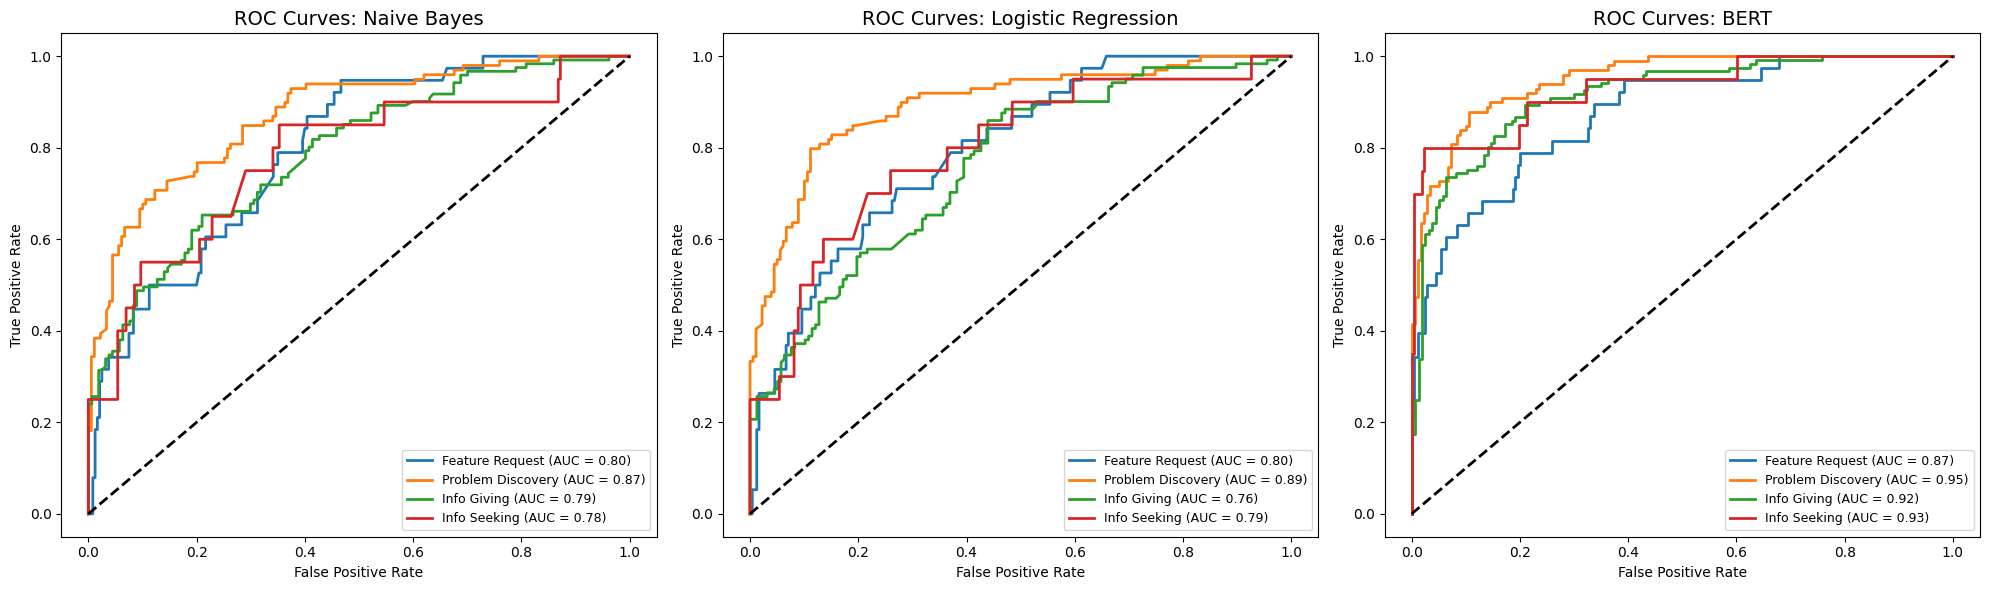

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Prepare data for plotting
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
class_labels = ["Feature Request", "Problem Discovery", "Info Giving", "Info Seeking"]
models_scores = [y_score_nb, y_score_lr, y_score_bert]
model_names = ["Naive Bayes", "Logistic Regression", "BERT"]

# 2. Create subplots for each model
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (y_score, name) in enumerate(zip(models_scores, model_names)):
    for i in range(4):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        axes[idx].plot(fpr, tpr, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc:0.2f})')
    
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[idx].set_title(f'ROC Curves: {name}', fontsize=14)
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].legend(loc="lower right", fontsize=9)

plt.tight_layout()
plt.show()

**5. Sample Usage**

In [31]:
# 1. Define custom samples
sample_reviews = [
    "I wish the app had a dark mode option for night reading.",       # Goal: Feature Request (0)
    "The app keeps crashing whenever I try to upload a photo.",     # Goal: Problem Discovery (1)
    "I have been using this app for two years and it is very stable.", # Goal: Info Giving (2)
    "How can I reset my password if I forgot the email?"            # Goal: Info Seeking (3)
]

# 2. Preprocess samples for Naive Bayes and Logistic Regression
samples_tfidf = tfidf.transform(sample_reviews)

# 3. Get Predictions
# Traditional Models
nb_preds = nb_model.predict(samples_tfidf)
lr_preds = clf.predict(samples_tfidf)

# BERT Model (requires tokenization)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = tokenizer(sample_reviews, padding=True, truncation=True, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
    bert_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# 4. Map back to human-readable labels
id_to_label = {0: "Feature Request", 1: "Problem Discovery", 2: "Info Giving", 3: "Info Seeking"}

# 5. Display the results in a clear table
import pandas as pd
demo_results = pd.DataFrame({
    'Input Review': sample_reviews,
    'Naive Bayes': [id_to_label[p] for p in nb_preds],
    'Logistic Regression': [id_to_label[p] for p in lr_preds],
    'BERT (Transformer)': [id_to_label[p] for p in bert_preds]
})

print("Prototype Live Testing Results:")
display(demo_results)

Prototype Live Testing Results:


,Input Review,Naive Bayes,Logistic Regression,BERT (Transformer)
0,I wish the app had a dark mode option for nigh...,Feature Request,Feature Request,Feature Request
1,The app keeps crashing whenever I try to uploa...,Problem Discovery,Problem Discovery,Problem Discovery
2,I have been using this app for two years and i...,Info Giving,Info Giving,Info Giving
3,How can I reset my password if I forgot the em...,Problem Discovery,Info Seeking,Info Seeking
